# Data Modeling

This notebook deals with processing the data, preparing it for modeling, performing the train/test splits, creating the pipelines, creating and training the models, comparing the models, and choosing the best model.

The following sections cover each of those steps.

## 1. General Imports

In [1]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay

import sklearn
print("-------- sklearn: ==========", sklearn.__version__)


-------- sklearn: ========== 1.6.1


## 2. Load the Data

In [2]:
# Load the data
df = pd.read_csv('../data/raw/framingham_heart_study.csv');
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## 3. Create the Features and Target

In [3]:
# Create the features and target
target = 'TenYearCHD'
X = df.drop(columns = [target])
y = df[target]

## 4. Create the Train/Test Splits

The training set will contain 80% of the data, and the testing set will represent the remaining 20%.

In [4]:
## Create the train/test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y
)

print(f'Train set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

Train set shape: (3392, 15)
Test set shape: (848, 15)


**Note:**
The `stratify = y` parameter keeps class imbalance consistent.

## 5. Preprocess the Pipeline

First, identify the numeric and categorical columns. Next, create a `ColumnTransformer` and apply the appropriate transformations to those columns.

**Note:**
The dataset contains numeric columns only; it doesn't have any categorical columns. So we'll only need a numeric transformer for the pipeline.

In [5]:
# Specify numeric and categorical columns
numeric_columns = X_train.select_dtypes(include = [np.number]).columns.tolist()

# Create the column transformer for the above column types
numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers = [
        ('numeric', numeric_transformer, numeric_columns)
    ]
)

**Note:**
Imputation is required due to missing values in `BMI`, `glucose`, `totChol`, `BPMeds`, and `education`.
Standard scaling improves logistic regression performance.
One-hot encoding allows categorical variables to be used effectively.

## 6. Create and Train the Baseline Model (Logistic Regression)
### 6.1. Create the model

In [6]:
# Create the Baseline Model (LogisticRegression)
baseline_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight = 'balanced', max_iter = 500, random_state = 42))
])
baseline_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['male', 'age', 'education',
                                                   'currentSmoker',
                                                   'cigsPerDay', 'BPMeds',
                                                   'prevalentStroke',
                                                   'prevalentHyp', 'diabetes',
                                                   'totChol', 'sysBP', 'diaBP',
                                                   'BMI', 'heartRate',
                                                   'glucose'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=500,
                                    random_state=42))])

### 6.2. Train the model and make predictions

In [7]:
baseline_model.fit(X_train, y_train)

baseline_preds = baseline_model.predict(X_test)
baseline_proba = baseline_model.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test, baseline_proba)
accuracy = accuracy_score(y_test, baseline_preds)
report = classification_report(y_test, baseline_preds)

print(f'ROC-AUC: {roc_auc:.2f}')
print(f'Accuracy: {accuracy:.2f}')
print(f'Classification Report: \n{report}')

ROC-AUC: 0.70
Accuracy: 0.67
Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.69      0.78       719
           1       0.25      0.60      0.36       129

    accuracy                           0.67       848
   macro avg       0.58      0.64      0.57       848
weighted avg       0.81      0.67      0.72       848



### 6.3. Plot the ROC curve

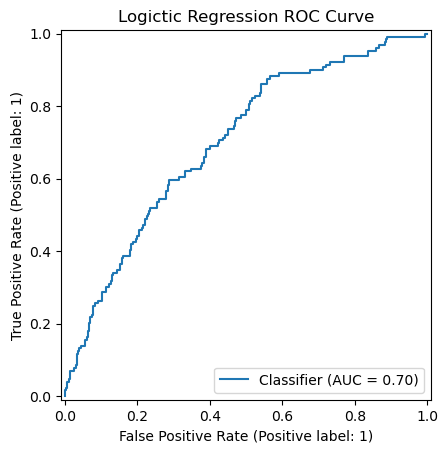

In [8]:
# Plot the ROC curve
RocCurveDisplay.from_predictions(y_test, baseline_proba)
plt.title('Logictic Regression ROC Curve')
plt.show()

## 7. Create and Train a Tree-Based Model (Random-Forest Classifier)
### 7.1. Create the model

In [9]:
rf_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators = 350,
        class_weight = 'balanced',
        random_state = 42
    ))
])
rf_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['male', 'age', 'education',
                                                   'currentSmoker',
                                                   'cigsPerDay', 'BPMeds',
                                                   'prevalentStroke',
                                                   'prevalentHyp', 'diabetes',
                                                   'totChol', 'sysBP', 'diaBP',
                                                   'BMI', 'heartRate',
                                                   'glucose'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=350, random_state=42))])

### 7.2. Train the model and make predictions

In [10]:
### 2. Train the model and make predictions

rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:,1]

rf_roc_auc = roc_auc_score(y_test, rf_proba)
rf_accuracy = accuracy_score(y_test, rf_preds)
rf_report = classification_report(y_test, rf_preds)

print(f'RFC - ROC-AUC: {rf_roc_auc:.3f}')
print(f'RFC - Accuracy: {rf_accuracy:.3f}')
print(f'RFC - Classification Report: \n{rf_report}')

RFC - ROC-AUC: 0.641
RFC - Accuracy: 0.846
RFC - Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       719
           1       0.33      0.02      0.03       129

    accuracy                           0.85       848
   macro avg       0.59      0.50      0.47       848
weighted avg       0.77      0.85      0.78       848



### 7.3. Plot the ROC Curve

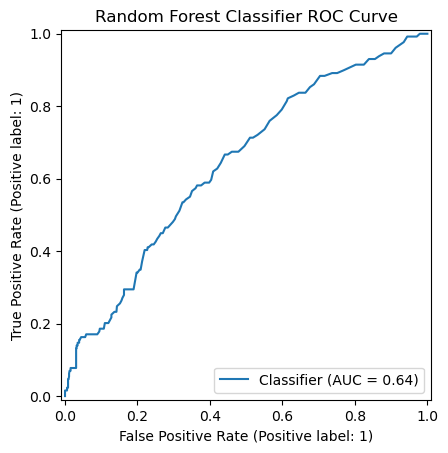

In [11]:
# Plot the ROC curve
RocCurveDisplay.from_predictions(y_test, rf_proba)
plt.title('Random Forest Classifier ROC Curve')
plt.show()

## 8. (Optional)Create and Train a Gradient Boosting Model
### 8.1. Create the model

In [12]:
gb_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        random_state = 42
    ))
])
gb_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['male', 'age', 'education',
                                                   'currentSmoker',
                                                   'cigsPerDay', 'BPMeds',
                                                   'prevalentStroke',
                                                   'prevalentHyp', 'diabetes',
                                                   'totChol', 'sysBP', 'diaBP',
                                                   'BMI', 'heartRate',
                                                   'glucose'])])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

### 8.2. Train the model and make predictions

In [13]:
### 2. Train the model and make predictions

gb_model.fit(X_train, y_train)

gb_preds = gb_model.predict(X_test)
gb_proba = gb_model.predict_proba(X_test)[:,1]

gb_roc_auc = roc_auc_score(y_test, gb_proba)
gb_accuracy = accuracy_score(y_test, gb_preds)
gb_report = classification_report(y_test, gb_preds)

print(f'GB - ROC-AUC: {gb_roc_auc:.3f}')
print(f'GB - Accuracy: {gb_accuracy:.3f}')
print(f'GB - Classification Report: \n{gb_report}')

GB - ROC-AUC: 0.662
GB - Accuracy: 0.842
GB - Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.98      0.91       719
           1       0.40      0.08      0.13       129

    accuracy                           0.84       848
   macro avg       0.63      0.53      0.52       848
weighted avg       0.79      0.84      0.79       848



### 8.3. Plot the ROC Curve

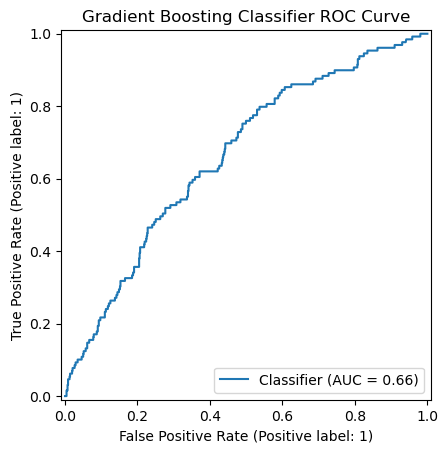

In [14]:
# Plot the ROC curve
RocCurveDisplay.from_predictions(y_test, gb_proba)
plt.title('Gradient Boosting Classifier ROC Curve')
plt.show()

## 9. Choose the Best Model

### Model Comparison

- **Logistic Regression:** ROC-AUC: **0.70**, Recall for class '1': **0.60**
- **Random Forest**: ROC-AUC: **0.64**, Recall for class '1': **0.02**
- **Gradient Boosting**: ROC-AUC: **0.66**, Recall for class '1': **0.08**

 The 'Logistic Regression' model has the best overall values for `ROC-AUC` and `Recall for class '1'`; so we'll choose it as our best model.

## 10. Save the Final Model

In [15]:
import joblib

joblib.dump(baseline_model, '../models/health_risk_model.joblib')

['../models/health_risk_model.joblib']